# **Machine Learning from Data**

## Lab 3: Feature selection using MDA


2021 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------

##Part3: A synthetic Gaussian dataset
##Feature selection by dimensionality reduction. PCA and MDA
##Colinear class centroids

In [20]:
import pandas as pd             #import pandas with the alias pd
import numpy as np              #import numpy with the alias np
import seaborn as sns           #import seaborn with the alias sns
import scipy.stats as ss
import matplotlib.pyplot as plt #import matplotlib.pyplot with the alias plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from numpy.random import default_rng
# initialize a random seed such that every execution will raise same random sequences of results
rng = default_rng(seed=5)

###Dataset mean and cov, aligned means

In [21]:
SNR = -5

# Design parameters
dist = 1
n_classes = 3
n_samples = 500
n_feat = 3

# M_Means matrix containing class means
M_Means = dist * np.array([[1, 0, 0],[0, 0, 0], [-1, 0, 0]])

# Energy computation
energy = 0
for i in range(0,n_classes):
  energy = energy + np.dot(M_Means[i],M_Means[i])
energy = energy / n_classes

# Noise variance computation
SNR = 10 ** (SNR/10)
sig = energy / SNR
sig = sig / n_feat

# Covariance matrix
M_covar = np.zeros(shape=(n_classes,n_feat,n_feat))
Vsig2 = np.array([0.1, 10, 10])
Vsig2 = 3 * Vsig2 / np.linalg.norm(Vsig2)
Vsig2 = sig * Vsig2

# H should be randn
H = rng.normal(size=(n_feat,n_feat))
#H = np.random.rand(n_feat,n_feat)

Heval, Hevec = np.linalg.eig(np.matmul(H,H.T))

M_Means = np.matmul(M_Means, Hevec)

for i in range(0,n_classes):
  M_covar[i,:,:] = np.matmul(Hevec.T, np.matmul(np.diag(Vsig2), Hevec))

print('Vsig2 ')
print(Vsig2)
print('M_covar ')
print(M_covar)
print('M_Means')
print(M_Means)

Vsig2 
[0.01490675 1.49067472 1.49067472]
M_covar 
[[[ 0.76021203  0.61786814 -0.40330716]
  [ 0.61786814  0.96804565  0.34114082]
  [-0.40330716  0.34114082  1.26799851]]

 [[ 0.76021203  0.61786814 -0.40330716]
  [ 0.61786814  0.96804565  0.34114082]
  [-0.40330716  0.34114082  1.26799851]]

 [[ 0.76021203  0.61786814 -0.40330716]
  [ 0.61786814  0.96804565  0.34114082]
  [-0.40330716  0.34114082  1.26799851]]]
M_Means
[[-0.70354192  0.59509697 -0.38844351]
 [ 0.          0.          0.        ]
 [ 0.70354192 -0.59509697  0.38844351]]


In [22]:
print(M_Means)

[[-0.70354192  0.59509697 -0.38844351]
 [ 0.          0.          0.        ]
 [ 0.70354192 -0.59509697  0.38844351]]


### Generate Gaussain training and test datasets

In [23]:
# Training dataset
X_train = np.empty((0,n_feat), float)
y_train = np.empty((0), int)
for i in range(0,n_classes):
  Xdata = rng.multivariate_normal(mean=M_Means[i,:], cov= M_covar[i,:,:], size= n_samples)
  ylab = i * np.ones((n_samples),dtype=int)
  X_train = np.append(X_train, Xdata, axis=0)
  y_train = np.append(y_train, ylab, axis=0)

# shuffle data (xdata and labels, same order)
#rp = np.random.permutation(len(X_train))
rp = rng.permutation(len(X_train))
X_train = X_train[rp]
y_train  = y_train[rp]


# Test dataset
X_test = np.empty((0,n_feat), float)
y_test = np.empty((0), int)
for i in range(0,n_classes):
  Xdata = rng.multivariate_normal(mean=M_Means[i,:], cov= M_covar[i,:,:], size= n_samples)
  ylab = i * np.ones((n_samples),dtype=int)
  X_test = np.append(X_test, Xdata, axis=0)
  y_test = np.append(y_test, ylab, axis=0)

# shuffle data (xdata and labels, same order)
#rp = np.random.permutation(len(X_test))
rp = rng.permutation(len(X_train))
X_test = X_test[rp]
y_test  = y_test[rp]

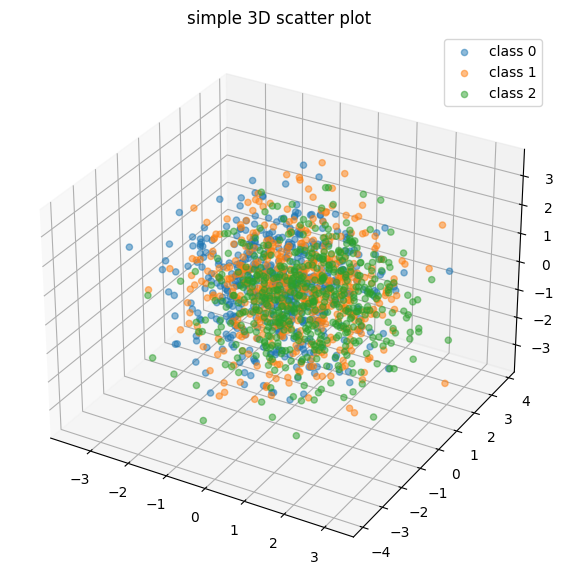

In [24]:
# 3D scatter plot (not interactive in colab!)

fig = plt.figure(figsize = (10,7))
ax = plt.axes(projection ="3d")
col = ['tab:blue','tab:orange', 'tab:green']
for idclass in range(0, n_classes):
  idx = y_train==idclass
  ax.scatter3D(X_train[idx,0], X_train[idx,1], X_train[idx,2], color = col[idclass], label='class %d' %idclass,alpha=0.5);

plt.title("simple 3D scatter plot")
plt.legend()
plt.show()

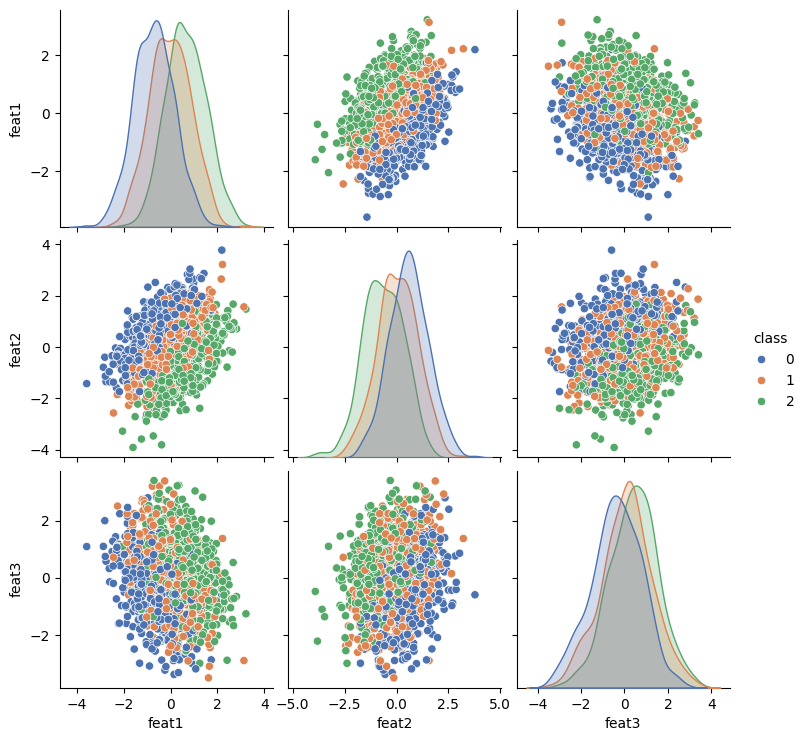

In [25]:
# scatter plot, original data
# create dataframex
Xt = pd.DataFrame(X_train,columns=['feat1','feat2','feat3'])
yt = pd.DataFrame(y_train,columns=['class'])
Xyt = Xt.join(yt)
#check dataframe
Xyt.head()
sns.pairplot(Xyt,hue='class',palette='deep');
plt.draw()

###Define LDA and QDA Classifiers

In [26]:
def lda_classifier(X_train, y_train, X_test, y_test):

  # Linear Discriminant Analysis
  lda = LinearDiscriminantAnalysis(solver="svd",store_covariance=True)
  ldamodel = lda.fit(X_train, y_train)
  y_tpred_lda = ldamodel.predict(X_train)
  y_testpred_lda = ldamodel.predict(X_test)

  lda_train_error = 1. - accuracy_score(y_train,y_tpred_lda)
  lda_train_cmat = confusion_matrix(y_train,y_tpred_lda)

  lda_test_error = 1. - accuracy_score(y_test,y_testpred_lda)
  lda_test_cmat = confusion_matrix(y_test,y_testpred_lda)

  lda_error = np.array([lda_train_error, lda_test_error])
  lda_cmat  = np.array([lda_train_cmat, lda_test_cmat])

  return lda, lda_error, lda_cmat

def qda_classifier(X_train, y_train, X_test, y_test):
  # Quadratic Discriminant Analysis
  qda = QuadraticDiscriminantAnalysis(store_covariance=True)
  qdamodel = qda.fit(X_train, y_train)
  y_tpred_qda = qdamodel.predict(X_train)
  y_testpred_qda = qdamodel.predict(X_test)

  qda_train_error = 1. - accuracy_score(y_train,y_tpred_qda)
  qda_train_cmat = confusion_matrix(y_train,y_tpred_qda)

  qda_test_error = 1. - accuracy_score(y_test,y_testpred_qda)
  qda_test_cmat = confusion_matrix(y_test,y_testpred_qda)

  qda_error = np.array([qda_train_error, qda_test_error])
  qda_cmat  = np.array([qda_train_cmat, qda_test_cmat])

  return qda, qda_error, qda_cmat

###Train and test LDA and QDA for 3D data

In [27]:
# LDA 3D
lda, lda_error, lda_cmat = lda_classifier(X_train,y_train,X_test,y_test)
print('LDA train error: %f ' %lda_error[0])
print('LDA train confusion matrix:')
print(lda_cmat[0])
print('LDA test error: %f ' %lda_error[1] )
print('LDA test confusion matrix:')
print(lda_cmat[1])

# QDA 3D
qda, qda_error, qda_cmat = qda_classifier(X_train,y_train,X_test,y_test)
print('QDA train error: %f ' %qda_error[0])
print('QDA train confusion matrix:')
print(qda_cmat[0])
print('QDA test error: %f ' %qda_error[1] )
print('QDA test confusion matrix:')
print(qda_cmat[1])

LDA train error: 0.000000 
LDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
LDA test error: 0.000000 
LDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA train error: 0.000000 
QDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA test error: 0.000000 
QDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]


###PCA: Project to 2 dim and classify with LDA and QDA


In [28]:
# PCA 2D
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca2 = pca.transform(X_train)
X_test_pca2  = pca.transform(X_test)

# Percentage of variance explained for each components
print('PCA PROJECTION TO 2D')
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# Train and test LDA and QDA classifiers
# LDA 2D
lda, lda_error, lda_cmat = lda_classifier(X_train_pca2,y_train,X_test_pca2,y_test)
print('LDA train error: %f ' %lda_error[0])
print('LDA train confusion matrix:')
print(lda_cmat[0])
print('LDA test error: %f ' %lda_error[1] )
print('LDA test confusion matrix:')
print(lda_cmat[1])

# QDA 2D
qda, qda_error, qda_cmat = qda_classifier(X_train_pca2,y_train,X_test_pca2,y_test)
print('QDA train error: %f ' %qda_error[0])
print('QDA train confusion matrix:')
print(qda_cmat[0])
print('QDA test error: %f ' %qda_error[1] )
print('QDA test confusion matrix:')
print(qda_cmat[1])

PCA PROJECTION TO 2D
explained variance ratio (first two components): [0.42280437 0.38920917]
LDA train error: 0.640000 
LDA train confusion matrix:
[[147 186 167]
 [134 192 174]
 [126 173 201]]
LDA test error: 0.658667 
LDA test confusion matrix:
[[154 165 181]
 [140 182 178]
 [140 184 176]]
QDA train error: 0.635333 
QDA train confusion matrix:
[[167 158 175]
 [149 164 187]
 [131 153 216]]
QDA test error: 0.664667 
QDA test confusion matrix:
[[153 165 182]
 [156 154 190]
 [147 157 196]]


###PCA 2D: then plots, scatter and boundaries

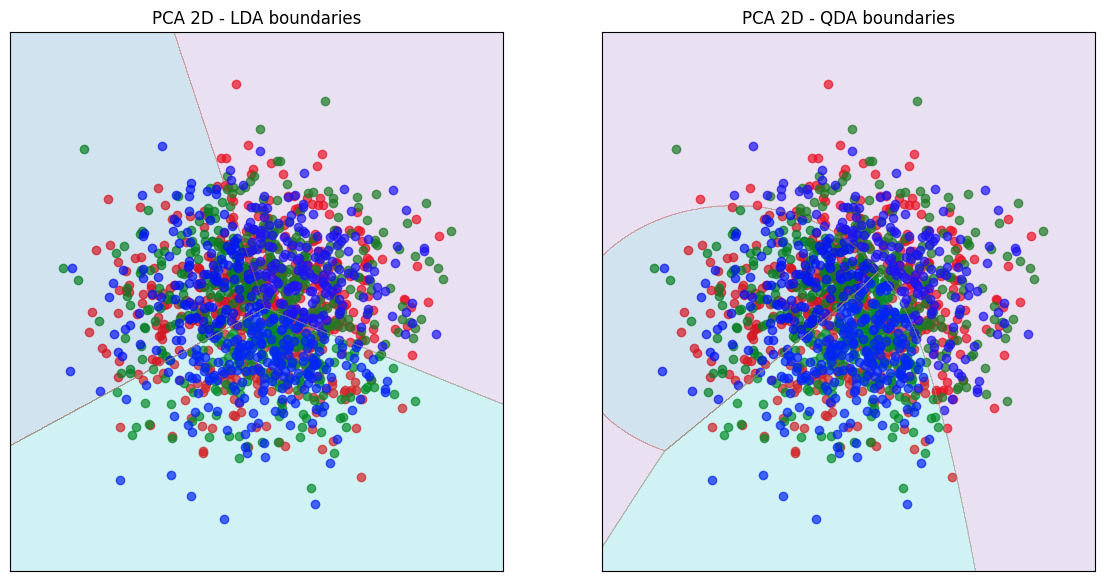

In [29]:
X = X_train_pca2
y = y_train

# For the lineal model
h = .01 # step size in the mesh
colors = ['r','g','b']
classes = ['1', '2', '3']

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig, ax = plt.subplots(figsize=(14,7),nrows=1, ncols=2)

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax[0].scatter(X[idx,0], X[idx,1], color = colors[idc], label='class %d' %idc,alpha=0.7);

ax[0].contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.2)

ax[0].set_xlim(xx.min(), xx.max())
ax[0].set_ylim(yy.min(), yy.max())
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('PCA 2D - LDA boundaries')

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot also the training points
for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax[1].scatter(X[idx,0], X[idx,1], color = colors[idc], label='class %d' %idc,alpha=0.7);

ax[1].contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.2)

ax[1].set_xlim(xx.min(), xx.max())
ax[1].set_ylim(yy.min(), yy.max())
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('PCA 2D - QDA boundaries')

plt.show()

###PCA: Now project to 1 dim and classify with LDA and QDA

In [30]:
# PCA 1D
pca = PCA(n_components=1)
pca.fit(X_train)
X_train_pca1 = pca.transform(X_train)
X_test_pca1  = pca.transform(X_test)

# Percentage of variance explained for each components
print('PCA PROJECTION TO 1D')
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# Train and test LDA and QDA classifiers
# LDA 1D
lda, lda_error, lda_cmat = lda_classifier(X_train_pca1,y_train,X_test_pca1,y_test)
print('LDA train error: %f ' %lda_error[0])
print('LDA train confusion matrix:')
print(lda_cmat[0])
print('LDA test error: %f ' %lda_error[1] )
print('LDA test confusion matrix:')
print(lda_cmat[1])

# QDA 1D
qda, qda_error, qda_cmat = qda_classifier(X_train_pca1,y_train,X_test_pca1,y_test)
print('QDA train error: %f ' %qda_error[0])
print('QDA train confusion matrix:')
print(qda_cmat[0])
print('QDA test error: %f ' %qda_error[1] )
print('QDA test confusion matrix:')
print(qda_cmat[1])

PCA PROJECTION TO 1D
explained variance ratio (first two components): [0.42280437]
LDA train error: 0.653333 
LDA train confusion matrix:
[[246 245   9]
 [232 263   5]
 [242 247  11]]
LDA test error: 0.657333 
LDA test confusion matrix:
[[254 240   6]
 [237 256   7]
 [247 249   4]]
QDA train error: 0.658000 
QDA train confusion matrix:
[[120 113 267]
 [115 115 270]
 [120 102 278]]
QDA test error: 0.658667 
QDA test confusion matrix:
[[141 101 258]
 [112 103 285]
 [123 109 268]]


###PCA 1D: scatter plot

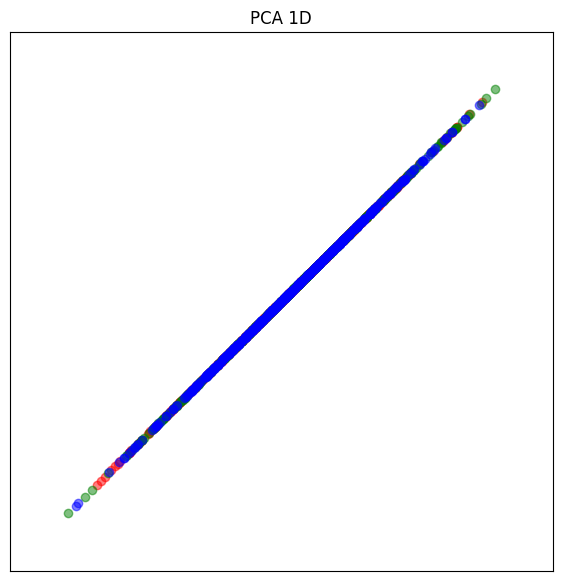

In [31]:
X = X_train_pca1
y = y_train

# For the lineal model
colors = ['r','g','b']
classes = ['1', '2', '3']

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig, ax = plt.subplots(figsize=(7,7))

for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax.scatter(X[idx,0], X[idx,0], color = colors[idc], label='class %d' %idc,alpha=0.5);

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('PCA 1D')

plt.show()

In [32]:
M_Means

array([[-0.70354192,  0.59509697, -0.38844351],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.70354192, -0.59509697,  0.38844351]])

###MDA (LDA in ScikitLearn): Project to 2 dim and classify with LDA and QDA


In [33]:
# MDA 2D
mda = LinearDiscriminantAnalysis(n_components=2)
mda.fit(X_train, y_train)
X_train_mda2 = mda.transform(X_train)
X_test_mda2  = mda.transform(X_test)

# Percentage of variance explained for each components
print('MDA PROJECTION TO 2D')
print('explained variance ratio (first two components): %s'
      % str(mda.explained_variance_ratio_))

# Train and test LDA and QDA classifiers
# LDA 2D
lda, lda_error, lda_cmat = lda_classifier(X_train_mda2,y_train,X_test_mda2,y_test)
print('LDA train error: %f ' %lda_error[0])
print('LDA train confusion matrix:')
print(lda_cmat[0])
print('LDA test error: %f ' %lda_error[1] )
print('LDA test confusion matrix:')
print(lda_cmat[1])

# QDA 2D
qda, qda_error, qda_cmat = qda_classifier(X_train_mda2,y_train,X_test_mda2,y_test)
print('QDA train error: %f ' %qda_error[0])
print('QDA train confusion matrix:')
print(qda_cmat[0])
print('QDA test error: %f ' %qda_error[1] )
print('QDA test confusion matrix:')
print(qda_cmat[1])

MDA PROJECTION TO 2D
explained variance ratio (first two components): [9.99965596e-01 3.44040674e-05]
LDA train error: 0.000000 
LDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
LDA test error: 0.000000 
LDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA train error: 0.000000 
QDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA test error: 0.000000 
QDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]


###MDA 2D: then plots, scatter and boundaries

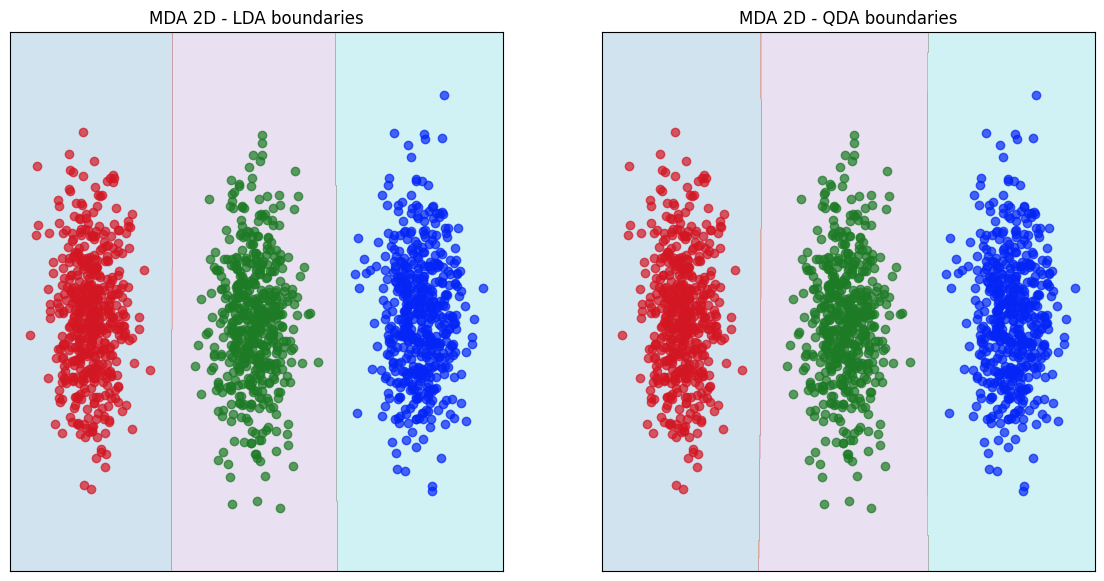

In [34]:
#plot 2D

X = X_train_mda2
y = y_train

# For the lineal model
h = .01 # step size in the mesh
colors = ['r','g','b']
classes = ['1', '2', '3']

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig, ax = plt.subplots(figsize=(14,7),nrows=1, ncols=2)

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax[0].scatter(X[idx,0], X[idx,1], color = colors[idc], label='class %d' %idc,alpha=0.7);

ax[0].contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.2)

ax[0].set_xlim(xx.min(), xx.max())
ax[0].set_ylim(yy.min(), yy.max())
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('MDA 2D - LDA boundaries')

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot also the training points
for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax[1].scatter(X[idx,0], X[idx,1], color = colors[idc], label='class %d' %idc,alpha=0.7);

ax[1].contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.2)

ax[1].set_xlim(xx.min(), xx.max())
ax[1].set_ylim(yy.min(), yy.max())
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('MDA 2D - QDA boundaries')

plt.show()

###MDA (LDA in ScikitLearn): Now project to 1 dim and classify with LDA and QDA

In [35]:
# MDA 1D
mda = LinearDiscriminantAnalysis(n_components=1)
mda.fit(X_train, y_train)
X_train_mda1 = mda.transform(X_train)
X_test_mda1  = mda.transform(X_test)

# Percentage of variance explained for each components
print('MDA PROJECTION TO 1D')
print('explained variance ratio (first two components): %s'
      % str(mda.explained_variance_ratio_))

# Train and test LDA and QDA classifiers
# LDA 1D
lda, lda_error, lda_cmat = lda_classifier(X_train_mda1,y_train,X_test_mda1,y_test)
print('LDA train error: %f ' %lda_error[0])
print('LDA train confusion matrix:')
print(lda_cmat[0])
print('LDA test error: %f ' %lda_error[1] )
print('LDA test confusion matrix:')
print(lda_cmat[1])

# QDA 1D
qda, qda_error, qda_cmat = qda_classifier(X_train_mda1,y_train,X_test_mda1,y_test)
print('QDA train error: %f ' %qda_error[0])
print('QDA train confusion matrix:')
print(qda_cmat[0])
print('QDA test error: %f ' %qda_error[1] )
print('QDA test confusion matrix:')
print(qda_cmat[1])

MDA PROJECTION TO 1D
explained variance ratio (first two components): [0.9999656]
LDA train error: 0.000000 
LDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
LDA test error: 0.000000 
LDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA train error: 0.000000 
QDA train confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]
QDA test error: 0.000000 
QDA test confusion matrix:
[[500   0   0]
 [  0 500   0]
 [  0   0 500]]


###MDA: plot 1D, LDA and *QDA*

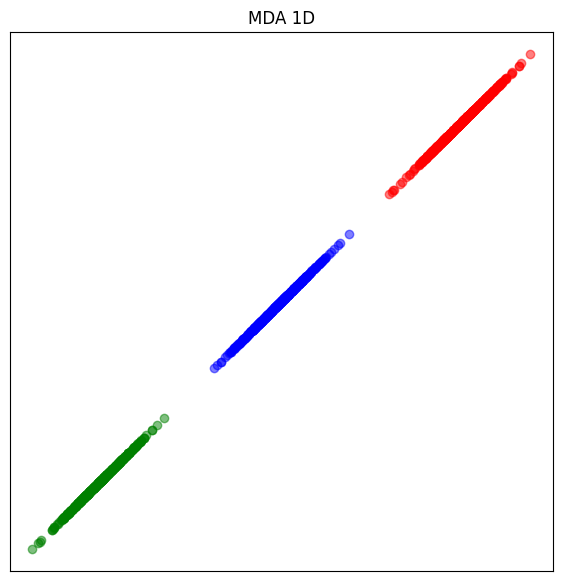

In [36]:
#MDA 1D
X = X_train_mda1
y = y_train

# For the lineal model
colors = ['g','b','r']
classes = ['1', '2', '3']

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

fig, ax = plt.subplots(figsize=(7,7))

for idc, nc in enumerate(classes):
  idx = y== (idc)
  ax.scatter(X[idx,0], X[idx,0], color = colors[idc], label='class %d' %idc,alpha=0.5);

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('MDA 1D')

plt.show()

In [37]:
M_Means

array([[-0.70354192,  0.59509697, -0.38844351],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.70354192, -0.59509697,  0.38844351]])